In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread

C:\Users\eromanr\.conda\envs\pytf\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


(360, 640, 3)
0
255


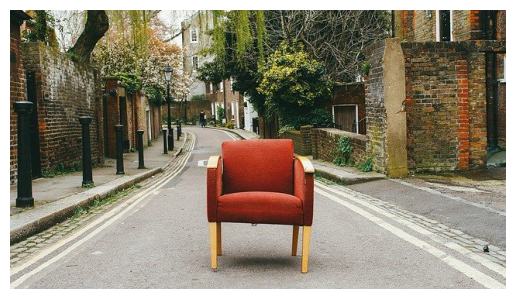

In [2]:
# Read example texture image in color
IMG1 = imread('chair-1840011_640.jpg')
print(IMG1.shape)
print(IMG1.min())
print(IMG1.max())

plt.imshow(IMG1)
plt.axis('off')
plt.show()

(360, 640)
0.0025
1.0


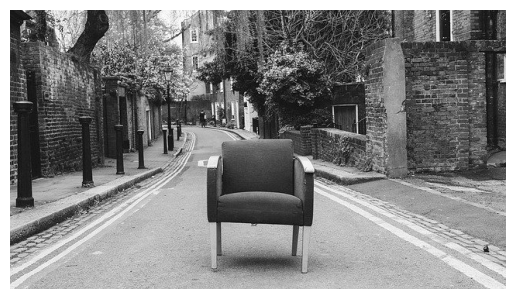

In [3]:
# Read example texture image
IMG1 = imread('chair-1840011_640.jpg', as_gray='True')
print(IMG1.shape)
print(IMG1.min())
print(IMG1.max())

plt.imshow(IMG1, cmap='gray')
plt.axis('off')
plt.show()

# Part 1: Example computing GIST

In [4]:
from GIST import GIST # Downloaded from https://github.com/imoken1122/GIST-feature-extractor

In [16]:
# Create GIST object, and see Gabor filters
param = {"orientationsPerScale":np.array([8, 8, 8, 8]),
         "numberBlocks":[4, 4],
         "fc_prefilt":10,
         "boundaryExtension":10
}

gist = GIST(param)
filters = gist._more_config(IMG1)
print(filters.shape)

(380, 660, 32)


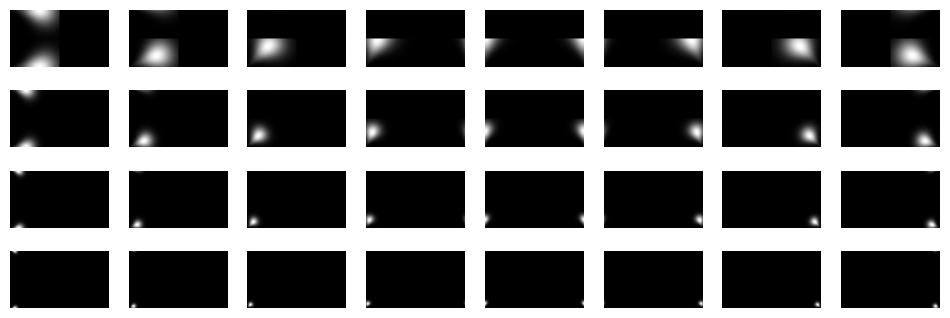

In [17]:
# Show filters
plt.figure(figsize=(12, 4))
for i in range(32):
  plt.subplot(4, 8, i+1)
  plt.imshow(filters[:, :, i], cmap='gray')
  plt.axis('off')
plt.show()

In [18]:
# Compute GIST descriptor for one example image
IMG1_gist = gist._gist_extract(IMG1)
print(IMG1_gist.shape)

(512,)


# Part 2: Example computing HoG

In [19]:
# Use skimage
from skimage.feature import hog
from skimage.transform import resize

In [20]:
# Compute HoG for one example image
IMG2 = resize(IMG1, (64, 128))# Resize to standard size for HoG

hog_desc, hog_img = hog(IMG2, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
print(hog_desc.shape)

(3780,)


(64, 128)


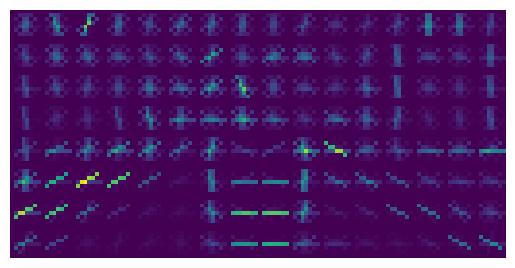

In [21]:
# Plot image
print(hog_img.shape)

plt.imshow(hog_img)
plt.axis('off')
plt.show()

In [22]:
# Some refs:
# https://www.learnopencv.com/histogram-of-oriented-gradients/
# https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

# Part 3: Classification with GIST and Gradient Boosting

In [23]:
from os import listdir
from os.path import join

In [24]:
# Dataset Caltech 101
# Source: http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html

In [26]:
# Find the name of each class
base_path = "Caltech_101"
class_names = listdir(base_path)
print("Num of classes:", len(class_names))

Num of classes: 102


In [27]:
# Load first 40 images from first class and a label for the class
print(class_names[0])
file_names1 = [join(base_path, class_names[0], f) for f in listdir(join(base_path, class_names[0]))]
X1 = np.array([resize(imread(f, as_gray='True'), (300, 200)) for f in file_names1[:40]])
Y1 = np.zeros((len(X1)))
print(X1.shape)
print(Y1.shape)

accordion
(40, 300, 200)
(40,)


In [28]:
# Load first 40 images from second class and a label for the class
print(class_names[1])
file_names2 = [join(base_path, class_names[1], f) for f in listdir(join(base_path, class_names[1]))]
X2 = np.array([resize(imread(f, as_gray='True'), (300, 200)) for f in file_names2[:40]])
Y2 = np.ones((len(X2)))
print(X2.shape)
print(Y2.shape)

airplanes
(40, 300, 200)
(40,)


In [29]:
# Concatenate data
X = np.concatenate((X1, X2))
Y = np.concatenate((Y1, Y2))
print(X.shape)
print(Y.shape)

(80, 300, 200)
(80,)


In [30]:
# Compute GIST for each image
param = {"orientationsPerScale":np.array([8, 8, 8, 8]),
         "numberBlocks":[4, 4],
         "fc_prefilt":10,
         "boundaryExtension":10}
gist = GIST(param)

GIST = np.array([gist._gist_extract(resize(img, (349, 352))) for img in X]) # Try with different image size
print(GIST.shape)

(80, 512)


In [45]:
# Imports for training a classifier with grid search
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
# Split train and test sets
x_train, x_test, y_train, y_test = train_test_split(GIST, Y, test_size=0.1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(72, 512)
(8, 512)
(72,)
(8,)


In [35]:
# Define grid search parameters
hyperparams = {'learning_rate': [0.001, 0.01, 0.1, 1.0],
               'n_estimators': [2, 5, 10, 20, 30],
               'max_depth': range(2, 7),
               'min_samples_split': range(2, 7, 2),
               'min_samples_leaf': range(1, 6, 2),
               'max_features': [None, 'sqrt', 'log2']}
hyperparams

{'learning_rate': [0.001, 0.01, 0.1, 1.0],
 'n_estimators': [2, 5, 10, 20, 30],
 'max_depth': range(2, 7),
 'min_samples_split': range(2, 7, 2),
 'min_samples_leaf': range(1, 6, 2),
 'max_features': [None, 'sqrt', 'log2']}

In [36]:
# Create and train the classifiers with grid search
gs_model = GridSearchCV(GradientBoostingClassifier(), hyperparams, verbose=True, n_jobs=-1)
gs_model.fit(x_train, y_train)

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'max_depth': range(2, 7),
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': range(1, 6, 2),
                         'min_samples_split': range(2, 7, 2),
                         'n_estimators': [2, 5, 10, 20, 30]},
             verbose=True)

In [37]:
# Print info about best model, its score and its hyperparameters
best_classifier = gs_model.best_estimator_

print(best_classifier)
print(f"Best score: {gs_model.best_score_:.3f}")
print(f"Best params: {gs_model.best_params_}")

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_features='sqrt',
                           n_estimators=10)
Best score: 1.000
Best params: {'learning_rate': 0.01, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


In [38]:
# Evaluate on both training and test set
print(f"Train mean accuracy: {best_classifier.score(x_train, y_train):.3f}")
print(f"Test mean accuracy: {best_classifier.score(x_test, y_test):.3f}")

Train mean accuracy: 1.000
Test mean accuracy: 1.000


In [46]:
# Let's see at the predicted classes
y_test_hat = best_classifier.predict(x_test)
print("Ground truth:", y_test)
print("Prediction  :", y_test_hat)

Ground truth: [1. 1. 0. 0. 0. 1. 0. 0.]
Prediction  : [1. 1. 0. 0. 0. 1. 0. 0.]


(2, 2)


<Figure size 400x400 with 0 Axes>

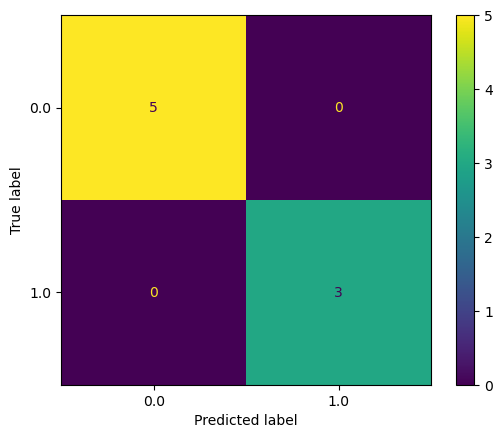

In [50]:
# Confusion matrix
CM = confusion_matrix(y_test, y_test_hat, labels=best_classifier.classes_)

plt.figure(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=best_classifier.classes_)
disp.plot()
plt.show()

# Part 4: Classification with HOG and Gradient Boosting

In [51]:
# Load first 40 images from first class and a label for the class
print(class_names[0])
file_names1 = [join(base_path, class_names[0], f) for f in listdir(join(base_path, class_names[0]))]
X1 = np.array([resize(imread(f, as_gray='True'), (64, 128)) for f in file_names1[:40]])
Y1 = np.zeros((len(X1)))
print(X1.shape)
print(Y1.shape)

accordion
(40, 64, 128)
(40,)


In [52]:
# Load first 40 images from second class and a label for the class
print(class_names[1])
file_names2 = [join(base_path, class_names[1], f) for f in listdir(join(base_path, class_names[1]))]
X2 = np.array([resize(imread(f, as_gray='True'), (64, 128)) for f in file_names2[:40]])
Y2 = np.ones((len(X2)))
print(X2.shape)
print(Y2.shape)

airplanes
(40, 64, 128)
(40,)


In [53]:
# Concatenate data
X = np.concatenate((X1, X2))
Y = np.concatenate((Y1, Y2))
print(X.shape)
print(Y.shape)

(80, 64, 128)
(80,)


In [54]:
# Compute HOG for each image
HOG = np.array([hog(img) for img in X])
print(HOG.shape)

(80, 6804)


In [55]:
# Split train and test sets
x_train, x_test, y_train, y_test = train_test_split(HOG, Y, test_size=0.1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(72, 6804)
(8, 6804)
(72,)
(8,)


In [56]:
# Define grid search parameters
hyperparams = {'learning_rate': [0.001, 0.01, 0.1, 1.0],
               'n_estimators': [2, 5, 10, 20, 30],
               'max_depth': range(2, 7),
               'min_samples_split': range(2, 7, 2),
               'min_samples_leaf': range(1, 6, 2),
               'max_features': [None, 'sqrt', 'log2']}
hyperparams

{'learning_rate': [0.001, 0.01, 0.1, 1.0],
 'n_estimators': [2, 5, 10, 20, 30],
 'max_depth': range(2, 7),
 'min_samples_split': range(2, 7, 2),
 'min_samples_leaf': range(1, 6, 2),
 'max_features': [None, 'sqrt', 'log2']}

In [57]:
# Create and train the classifiers with grid search
gs_model = GridSearchCV(GradientBoostingClassifier(), hyperparams, verbose=True, n_jobs=-1)
gs_model.fit(x_train, y_train)

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'max_depth': range(2, 7),
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': range(1, 6, 2),
                         'min_samples_split': range(2, 7, 2),
                         'n_estimators': [2, 5, 10, 20, 30]},
             verbose=True)

In [58]:
# Print info about best model, its score and its hyperparameters
best_classifier = gs_model.best_estimator_

print(best_classifier)
print(f"Best score: {gs_model.best_score_:.3f}")
print(f"Best params: {gs_model.best_params_}")

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=6,
                           n_estimators=30)
Best score: 1.000
Best params: {'learning_rate': 0.01, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 30}


In [59]:
# Evaluate on both training and test set
print(f"Train mean accuracy: {best_classifier.score(x_train, y_train):.3f}")
print(f"Test mean accuracy: {best_classifier.score(x_test, y_test):.3f}")

Train mean accuracy: 1.000
Test mean accuracy: 1.000


In [60]:
# Let's see at the predicted classes
y_test_hat = best_classifier.predict(x_test)
print("Ground truth:", y_test)
print("Prediction  :", y_test_hat)

Ground truth: [1. 1. 0. 1. 1. 0. 0. 1.]
Prediction  : [1. 1. 0. 1. 1. 0. 0. 1.]


<Figure size 400x400 with 0 Axes>

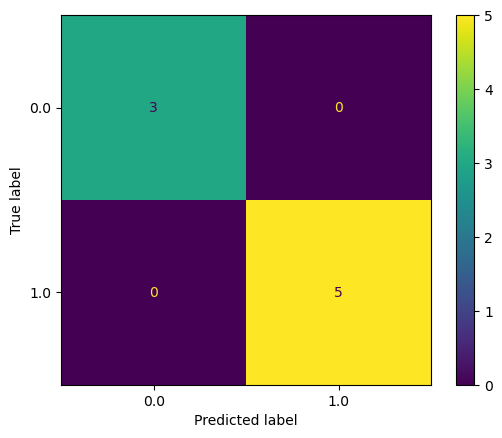

In [61]:
# Confusion matrix
CM = confusion_matrix(y_test, y_test_hat, labels=best_classifier.classes_)

plt.figure(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=best_classifier.classes_)
disp.plot()
plt.show()

# Part 5: Mini-project - Image classification

In [29]:
# %reset
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from GIST import GIST

In [28]:
# Size for images
nrows = 349
ncols = 352

In [ ]:
# == Q1 ==
# Encuentra una manera de cargar 40 imágenes por cada clase del dataset Caltech 101 y almancenarlas en un sólo tensor X.
# Tú decide el tamaño de cada imágen. Asigna una etiqueta (números enteros) a cada clase, y crea el vector Y cuya longitud
# sea igual a X, y en donde cada elemento de Y indique la clase de su correspondiente imagen en X.
# Reporta las longitudes de los arreglo X e Y, el tamaño de las imagénes, y los valores mínimo y máximo de la magnitud de
# los píxeles.

In [30]:
# Find the name of each class
base_path = "Caltech_101"
class_names = listdir(base_path)
print("Num of classes:", len(class_names))

# Load first 40 images from each class and label them
X = np.empty(shape=(0, nrows, ncols))
Y = np.empty(shape=(0))
for cl in range(len(class_names)):
    files = [join(base_path, class_names[cl], f) for f in listdir(join(base_path, class_names[cl]))]
    X1 = np.array([resize(imread(f, as_gray='True'), (nrows, ncols)) for f in files[:40]])
    X = np.concatenate((X, X1))
    Y = np.concatenate((Y, cl * np.ones((len(X1)))))
    
print(X.shape)
print(X.min())
print(X.max())
print(Y.shape)
print(Y.min())
print(Y.max())

Num of classes: 55
(2133, 349, 352)
0.0
1.0
(2133,)
0.0
54.0


In [31]:
# == Q2 ==
# Calcula el descriptor GIST para cada imagen.
# Revisa la documentación de sklearn.neighbors.KNeighborsClassifier. Usa KNeighborsClassifier junto con los descriptores
# GIST para clasificar las imágenes
# Reporta la exactitud de clasificación.

In [32]:
# Compute GIST for each image
# Puede tardar un rato, ya que son muchas imágenes
param = {"orientationsPerScale":np.array([8, 8, 8, 8]),
         "numberBlocks":[4, 4],
         "fc_prefilt":10,
         "boundaryExtension":32}

gist = GIST(param)
X_GIST = np.array([gist._gist_extract(img) for img in X])
print(X_GIST.shape)

(2133, 512)


In [33]:
# Train classifier
kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(X_GIST, Y)

# Predict
y_hat = kNN.predict(X_GIST)
acc = kNN.score(X_GIST, Y)
print(f"Accuracy: {acc}")

Accuracy: 1.0


In [34]:
# == Q3 ==
# Usa el modelo grid search evalúa el desempeño de clasificación para:
# numberBlocks de GIST = 4x4, 7x7, 10x10, y
# clasificador kNN con k = 1, 3, 5, 10
# Puede reportar los resultados de exactitud en una tabla de 3 filas con 4 columnas

In [35]:
# AUX function to compute GIST with different hyperparameters
def get_GIST(nblocks):
    # Compute GIST for each image
    param = {"orientationsPerScale":np.array([8, 8, 8, 8]), "numberBlocks":[nblocks, nblocks],
             "fc_prefilt":10, "boundaryExtension":32}
    gist = GIST(param)
    X_GIST = np.array([gist._gist_extract(img) for img in X])
    return X_GIST

In [ ]:
# Get table from 2 nested loops
for nblocks in [4, 7, 8]:
    print(f"Num blocks: {nblocks:2d}x{nblocks:2d} --", end='\t')
    X_GIST = get_GIST(nblocks)
    for nn in [1, 3, 5, 10]:
        kNN = KNeighborsClassifier(n_neighbors=nn)
        kNN.fit(X_GIST, Y)
        acc = kNN.score(X_GIST, Y)
        print(f"nn: {nn:2d} - acc: {acc:4.2f}", end=', ')
    print("")

Num blocks:  4x 4 --	nn:  1 - acc: 1.00, nn:  3 - acc: 0.62, nn:  5 - acc: 0.56, nn: 10 - acc: 0.51, 
Num blocks:  7x 7 --	nn:  1 - acc: 1.00, nn:  3 - acc: 0.63, nn:  5 - acc: 0.57, nn: 10 - acc: 0.52, 
Num blocks:  8x 8 --	nn:  1 - acc: 1.00, nn:  3 - acc: 0.63, nn:  5 - acc: 0.56, nn: 10 - acc: 0.50, 


In [ ]:
# Classification performance is the same. Keep shortest descriptor as best ones
# Compute GIST only for one image and different number of blocks, just to see which one is the shortest
for nblocks in [4, 7, 8]:
    param = {"orientationsPerScale":np.array([8, 8, 8, 8]), "numberBlocks":[nblocks, nblocks],
             "fc_prefilt":10, "boundaryExtension":32}
    gist = GIST(param)
    print(f"Num blocks: {nblocks:2d}x{nblocks:2d} -- size = {gist._gist_extract(X[0]).shape}")

Num blocks:  4x 4 -- size = (512,)
Num blocks:  7x 7 -- size = (1568,)
Num blocks:  8x 8 -- size = (2048,)


In [ ]:
# == Q4 ==
# Revisa la documentación sklearn.metrics.confusion_matrix y crea la matriz de confusión para el mejor modelo obtenido
# con la búsqueda de la pregunta anterior.
# Grafica la matriz

In [ ]:
# Use nbloks = 4x4 (shortest) and 1NN: Compute GIST, kNN and predict.
param = {"orientationsPerScale":np.array([8, 8, 8, 8]), "numberBlocks":[4, 4], "fc_prefilt":10, "boundaryExtension":32}
gist = GIST(param)
X_GIST = np.array([gist._gist_extract(img) for img in X])
kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(X_GIST, Y)
print(f"Accuracy: {kNN.score(X_GIST, Y)}")
y_hat = kNN.predict(X_GIST)
print(y_hat.shape)

Accuracy: 1.0
(4009,)


(102, 102)


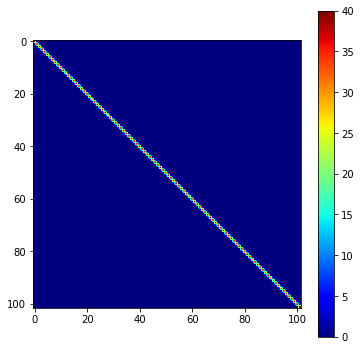

In [ ]:
# Confusion matrix
CM = confusion_matrix(Y, y_hat)
print(CM.shape)

plt.figure(figsize=(6, 6))
plt.imshow(CM, cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
# == Q5 ==
# Ahora calcula los descriptores HoG para las imágenes en X (tú decide si las rescalas o no)
# Usando grid search, evalua el impacto sobre la exactitud de clasificación kNN de los siguientes parámetros
# orientations = 4, 9, 16,
# cells_per_block = (1, 1), (2, 2), (3, 3)
# Reporta los resultados en una tabla

In [ ]:
# Revisa accuracy con distintos valores de parámetros
print(f"\t \t Cells per block")
print(f"Orientations:\t 1x1 \t 2x2 \t 3x3")
for orient in [4, 9, 16]:
    print(f"\t {orient:2d} \t", end='')
    for cells in [1, 2, 3]:
        X_HOG = np.array([hog(img, orientations=orient, pixels_per_cell=(8, 8), cells_per_block=(cells, cells)) for img in X])
        kNN = KNeighborsClassifier(n_neighbors=1)
        kNN.fit(X_HOG, Y)
        print(f"{kNN.score(X_HOG, Y):4.2f}", end='\t', flush=True)
    print('')

	 	 Cells per block
Orientations:	 1x1 	 2x2 	 3x3
	  4 	1.00	1.00	1.00	
	  9 	1.00	1.00	1.00	
	 16 	1.00	1.00	1.00	


In [ ]:
# == Q6 ==
# ¿El cambio en el valor de los parámetros evaluados en la pregunta anterior tiene algún impacto en la longitud del
# descriptor? ¿Por qué?

In [ ]:
# Revisa tamaño con una sola imagen: process just 1 image
print(f"\t \t Cells per block")
print(f"Orientations:\t 1x1 \t 2x2 \t 3x3")
for orient in [4, 9, 16]:
    print(f"\t {orient:2d} \t", end='')
    for cells in [1, 2, 3]:
        h = hog(X[0], orientations=orient, pixels_per_cell=(8, 8), cells_per_block=(cells, cells))
        print(f"{h.shape}", end='\t', flush=True)
    print('')

	 	 Cells per block
Orientations:	 1x1 	 2x2 	 3x3
	  4 	(7568,)	(28896,)	(61992,)	
	  9 	(17028,)	(65016,)	(139482,)	
	 16 	(30272,)	(115584,)	(247968,)	


In [ ]:
# Sí. Como indica la tabla anterior, ambos parámetros influyen en el tamaño del descriptor.
# El número de orientaciones indica el número de bins en el histograma de cada celda. Entre mayor sea, más largo es el descriptor.
# Y el número de celdas por bloque, indica cuantos histogramas se concatenan juntos. Entre mayor sea, más largo es el descriptor.

In [ ]:
# == Q7 ==
# Muestra la matriz de confusión para la mejor combinación de parámetros de HoG

Accuracy: 1.0
(4009,)
(102, 102)


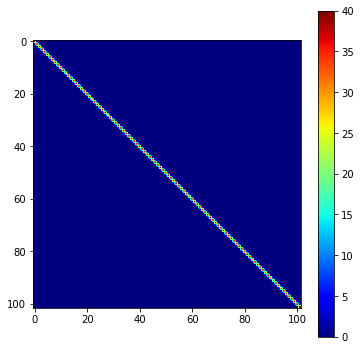

In [ ]:
# Igual podemos elegir la más corta
X_HOG = np.array([hog(img, orientations=4, pixels_per_cell=(8, 8), cells_per_block=(1, 1)) for img in X])
kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(X_HOG, Y)
print(f"Accuracy: {kNN.score(X_HOG, Y)}")
y_hat = kNN.predict(X_HOG)
print(y_hat.shape)

# Confusion matrix
CM = confusion_matrix(Y, y_hat)
print(CM.shape)

plt.figure(figsize=(6, 6))
plt.imshow(CM, cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
# == Q8 ==
# Según la evaluación anterior, ¿qué descriptor parece ser más adecuado para esta base de datos, GIST o HoG?
# ¿Por qué crees que sea así?

In [ ]:
# Ambos son capaces de obtener exactitud de clasificación = 1.
# Sin embargo, si comparamos la longitud de los vectores, podrímos pensar que GIST tiene mejor desemepeño.

In [ ]:
# Some useful links
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
# Some extra refs for more datasets:
# https://analyticsindiamag.com/10-open-datasets-you-can-use-for-computer-vision-projects/
# http://www.cvpapers.com/datasets.html